In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sys import path
from os.path import abspath
path.append(abspath("/home/ng136/nico"))
import ng_functions as ng

from glob import glob
from pathlib import Path
import warnings
from time import time
from tqdm import tqdm
from datetime import datetime

# Load datasets

In [4]:
n_states = ['N1a', 'N1b', 'N2', 'N3', 'N4', 'N5', 'N6']

# Zilionis

In [5]:
zdata = sc.read('/n/groups/klein/nico/neutrophils/backups/zilionis_mouse_reannotated_15939x27045_backup_220323_16h11.h5ad')

In [6]:
zdata.layers['umi'] = zdata.X.copy()
zdata.X = zdata.layers['cp10k'].copy()

In [7]:
zdata = zdata[zdata.obs['state_label'].isin(n_states)].copy()

## Gungabeesoon

## Untreated

In [12]:
ndata_all = sc.read('/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_all_cells_untreated_annotated_embedding_8404x13126_backup_220325_11h55.h5ad')
ndata_all = ndata_all[ndata_all.obs['sample_condition'].isin(['KP19', 'KP19_CD101'])].copy()

In [58]:
ndata_all.shape[0]

4892

In [10]:
ndata = sc.read("/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_untreated_annotated_embedding_5258x13126_backup_220422_15h46.h5ad")
ndata.layers['umi'] = ndata.X.copy()
ndata.X = ndata.layers['cp10k'].copy()

In [14]:
ndata.obs['N_label'] = ndata.obs['smoothed_Zilionis']

In [17]:
ndata.obs['library_name'].value_counts()

2.KP19          1433
1.KP19          1214
2.WT             917
2.KP19_CD101     680
1.KP19_CD101     600
1.WT             414
Name: library_name, dtype: int64

In [20]:
ndata = ndata[ndata.obs['sample_condition'].isin(['KP19', 'KP19_CD101'])].copy()

## Treated

In [24]:
tdata_all = sc.read("/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_all_cells_acd40_annotated_embedding_33603x17824_backup_220325_12h01.h5ad")

In [25]:
tdata = sc.read("/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_neutrophils_acd40_annotated_embedding_25210x17824_backup_220422_15h46.h5ad")
tdata.layers['umi'] = tdata.X.copy()
tdata.X = tdata.layers['cp10k'].copy()

In [26]:
tdata.obs['N_label'] = tdata.obs['smoothed_Zilionis']

In [30]:
tdata_all.obs['library_name'].value_counts()

1.KP19_CXCL10pos    8928
2.KP19_CXCL10pos    8879
1.KP19_CXCL10neg    7898
2.KP19_CXCL10neg    7898
Name: library_name, dtype: int64

In [27]:
tdata_all.shape[0]

33603

## Garris

In [40]:
gdata = sc.read('/n/groups/klein/nico/neutrophils/data/rss_marius/adata_garris_neu_12012020.h5ad')
print('No. of cells: \n',gdata.obs['Treatment'].value_counts())
gdata = gdata[gdata.obs['res_0.5'] == '4']

No. of cells: 
 aPD1       2942
Control    1015
Name: Treatment, dtype: int64


In [41]:
gdata.obs['N_label'] = pd.DataFrame(**np.load('/n/groups/klein/nico/neutrophils/backups/loglikelihoods_multinomial_naive_bayes_garris_neutrophils_by_zilionis_reannotated_220614_02h55.npz', allow_pickle=True)).idxmax(0).values

Trying to set attribute `.obs` of view, copying.


In [42]:
gdata_nt = gdata[gdata.obs['Treatment'] == 'Control'].copy()
gdata_apd1 = gdata[gdata.obs['Treatment'] == 'aPD1'].copy()

## Siwicki

In [48]:
sdata_raw = sc.read("/n/groups/klein/nico/tox/backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200604_01h08.h5ad")
sdata_raw.obs['label_Zilionis'] = pd.DataFrame(**np.load("/n/groups/klein/nico/tox/backups/loglikelihoods_bay_classif_tox_marie_all_cells_200423_20h42.npz", allow_pickle=True)).idxmax().values

sdata = sc.read('/home/ng136/nico/tox/backups/tox_marie_processed_data_with_raw_all_cells_34659x22631_backup_210102_20h25.h5ad')
sdata = sdata[(~sdata.obs['predicted_doublet']) & (~sdata.obs['leiden_minor_subset'].isin(['Hepatocytes', 'RBC', 'EC1', 'EC2']))]
sdata.obs['label_Zilionis'] = sdata_raw.obs['label_Zilionis'].astype('category')

print('No. of cells: \n',sdata[sdata.obs['tissue'] == 'Tumor'].obs['treatment'].value_counts())

sdata = sdata[sdata.obs['leiden'].isin(['0', '4', '15', '20', '21'])]

sdata.obs['N_label'] = pd.DataFrame(**np.load('/n/groups/klein/nico/neutrophils/backups/loglikelihoods_multinomial_naive_bayes_siwicki_neutrophils_by_zilionis_reannotated_220614_02h56.npz', allow_pickle=True)).idxmax(0).values

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


No. of cells: 
 Trx    6373
NT     1399
Name: treatment, dtype: int64


In [49]:
sdata_tumor_nt = sdata[(sdata.obs['treatment'] == 'NT') & (sdata.obs['tissue'] == 'Tumor') & (sdata.obs['marker'] == 'CD45pos')].copy()
sdata_tumor_acd40 = sdata[(sdata.obs['treatment'] == 'Trx') & (sdata.obs['tissue'] == 'Tumor') & (sdata.obs['marker'] == 'CD45pos')].copy()

# Concatenate datasets

In [51]:
datasets = {'Gungabeesoon KP19 untreated': ndata,
             'Gungabeesoon KP19 aCD40': tdata,
             'Garris MC38 untreated': gdata_nt,
             'Garris MC38 aPD1': gdata_apd1,
             'Siwicki MC38 untreated': sdata_tumor_nt,
             'Siwicki MC38 aCD40': sdata_tumor_acd40}

for i in datasets.keys():
    datasets[i] =  datasets[i][datasets[i].obs['N_label'].isin(datasets[i].obs['N_label'].value_counts().index)].copy()

## Incorporate absolute no. of immune cells information from each dataset

In [73]:
total_immune_per_dataset = pd.Series({'Gungabeesoon KP19 untreated': 4892,
             'Gungabeesoon KP19 aCD40': 33603,
             'Garris MC38 untreated': 1015,
             'Garris MC38 aPD1': 2942,
             'Siwicki MC38 untreated': 1399,
             'Siwicki MC38 aCD40': 6373})

# Compute changes in abundance (%)

In [74]:
neutrophil_abundances_per_dataset = pd.concat([d.obs['N_label'].value_counts(normalize=False).rename(dataset_name).reindex(['N1a', 'N1b', 'N2', 'N3', 'N4', 'N5', 'N6']).fillna(0) for dataset_name, d in datasets.items()], 
                                              axis=1).T

neutrophil_abundances_per_dataset['Sellhi'] = neutrophil_abundances_per_dataset.loc[:,['N1a','N1b','N2']].sum(1)

neutrophil_abundances_per_dataset = neutrophil_abundances_per_dataset.div(total_immune_per_dataset, axis=0)

In [76]:
neutrophil_abundances_per_dataset = neutrophil_abundances_per_dataset.T

In [77]:
pop_changes_after_treatment = pd.DataFrame({'KP19 + aCD40': neutrophil_abundances_per_dataset['Gungabeesoon KP19 aCD40'] / (neutrophil_abundances_per_dataset['Gungabeesoon KP19 untreated']),
'MC38 + aCD40': (neutrophil_abundances_per_dataset['Siwicki MC38 aCD40']) / (neutrophil_abundances_per_dataset['Siwicki MC38 untreated']),
'MC38 + aPD1': (neutrophil_abundances_per_dataset['Garris MC38 aPD1']) / (neutrophil_abundances_per_dataset['Garris MC38 untreated'])}).T

# Plot

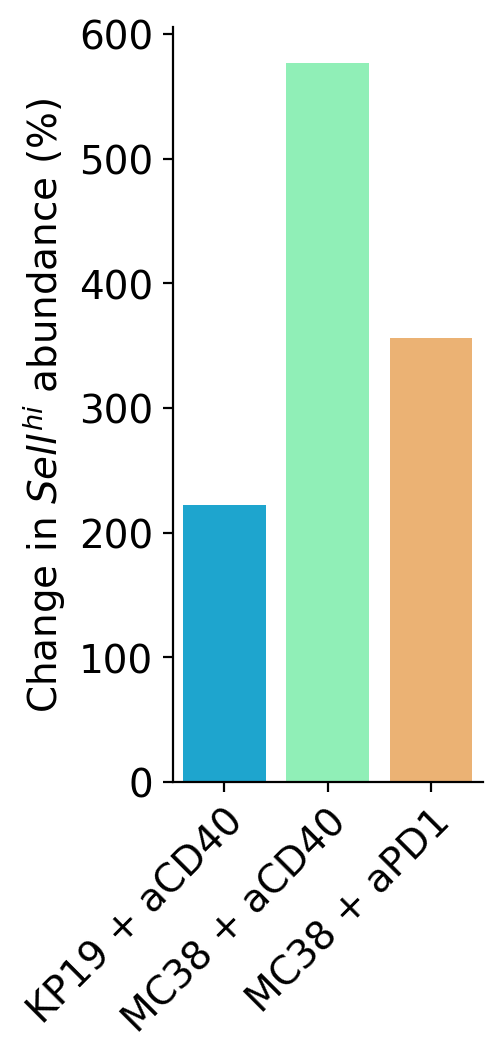

In [79]:
with sns.plotting_context({'font.size':14, 'figure.dpi':200, 'figure.figsize':(2,5)}):
    sns.barplot(x=pop_changes_after_treatment.index, y=100*(pop_changes_after_treatment['Sellhi']-1),
               palette='rainbow')

    plt.gca().set_ylabel('Change in $Sell^{hi}$ abundance (%)')
    plt.gca().tick_params(axis='x', rotation=45)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    sns.despine()